In [1]:
## The Baseline Method only use simple gait parameter feature, it only includes 2 dense layers
import scipy.io
import numpy as np
import random

## We delete people's data with low feedback score and remove people who kicked off the sensors during walking'
## So 20 people in total.
person_nums = [1,2,4,5,6,8,9,10,11,12,13,17,19,21,22,25,26,27,28,29]

from feature_emotion import feature_extract, split_data, label_unique_tuples
gts, sensor_nums, walk_nums, trace_nums, people_nums, spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features = feature_extract(person_nums)

walk_nums_all = np.squeeze(walk_nums)
trace_nums_all = np.squeeze(trace_nums)
people_nums_all = np.squeeze(people_nums)

## 0: train, 1: validation 2: test
flag_tr_val_te = split_data(walk_nums_all, trace_nums_all, people_nums_all)

In [2]:
## Data Normalization before training ans testing
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, LSTM
from sklearn.preprocessing import StandardScaler
scalers = []
X_train_normalized = []
X_val_normalized = []
X_test_normalized = []
train_idx = np.where(flag_tr_val_te ==0)[0]
np.random.shuffle(train_idx)
val_idx = np.where(flag_tr_val_te ==1)[0]
test_idx = np.where(flag_tr_val_te ==2)[0]

for i, feature in enumerate([spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features]):
    scaler = StandardScaler()
    if len(feature.shape)==2:
        X_train_i = feature[train_idx,:]
        X_val_i = feature[val_idx,:]
        X_test_i = feature[test_idx,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i)
        X_val_normalized_i = scaler.transform(X_val_i)
        X_test_normalized_i = scaler.transform(X_test_i)
        scalers.append(scaler)
    else:
        X_train_i = feature[train_idx,:,:]
        X_val_i = feature[val_idx,:,:]
        X_test_i = feature[test_idx,:,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i.reshape(X_train_i.shape[0], -1)).reshape(X_train_i.shape)
        X_val_normalized_i = scaler.transform(X_val_i.reshape(X_val_i.shape[0], -1)).reshape(X_val_i.shape)
        X_test_normalized_i = scaler.transform(X_test_i.reshape(X_test_i.shape[0], -1)).reshape(X_test_i.shape)
        scalers.append(scaler)
    X_train_normalized.append(X_train_normalized_i)
    X_val_normalized.append(X_val_normalized_i)
    X_test_normalized.append(X_test_normalized_i)
y_train = gts[train_idx,:]
y_val = gts[val_idx,:]
y_test = gts[test_idx,:]

2023-11-06 22:57:38.024478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def new_label_gen(old_labels):
    new_labels = np.zeros((old_labels.shape[0],))
    
    # Define classes based on conditions
    new_labels[np.logical_and(old_labels[:, 0] <= 5, old_labels[:, 1] < 5)] = 0
    new_labels[np.logical_and(old_labels[:, 0] > 5, old_labels[:, 1] < 5)] = 1
    new_labels[np.logical_and(old_labels[:, 0] <= 5, old_labels[:, 1] >= 5)] = 2
    new_labels[np.logical_and(old_labels[:, 0] > 5, old_labels[:, 1] >= 5)] = 3
    
    # If you need one-hot encoded labels for the classification output
    one_hot_new_labels = np.eye(4)[new_labels.astype(int)]
    return one_hot_new_labels
y_train_class = new_label_gen(y_train)
y_val_class = new_label_gen(y_val)
y_test_class = new_label_gen(y_test)

In [4]:
X_train_normalized_new = []
combined_feature = np.empty((len(X_train_normalized[0]),0))
for feature in X_train_normalized:
    if len(feature.shape) == 3:
        X_train_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_train_normalized_new.append(feature)
X_train_normalized_new.append(combined_feature)

X_val_normalized_new = []
combined_feature = np.empty((len(X_val_normalized[0]),0))
for feature in X_val_normalized:
    if len(feature.shape) == 3:
        X_val_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_val_normalized_new.append(feature)
X_val_normalized_new.append(combined_feature)

X_test_normalized_new = []
combined_feature = np.empty((len(X_test_normalized[0]),0))
for feature in X_test_normalized:
    if len(feature.shape) == 3:
        X_test_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_test_normalized_new.append(feature)
X_test_normalized_new.append(combined_feature)

In [5]:
## Build the baseline model for emotion recognition with dropout layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, SimpleRNN, LSTM, Conv2D, Flatten, MaxPooling2D, GRU, AveragePooling2D, Dropout, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
def individual_model(features_list):
    input_layers = []
    hidden_layers = []
    combined_feature = np.empty((len(features_list[0]),0))
    for i, feature in enumerate(features_list):
        
        if len(feature.shape) == 3:
            input_i = Input(shape=(feature.shape[1], feature.shape[2]))
            input_layers.append(input_i)

            hidden_i = input_i[:,:,:,None]
            hidden_i = Conv2D(32, 3, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((3, 3))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Conv2D(16, 3, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((3, 3))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Conv2D(8, 1, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((2, 2))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Conv2D(4, 1, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((2, 2))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Flatten()(hidden_i)

            hidden_layers.append(hidden_i)
        elif feature.shape[1] <20:
            combined_feature = np.hstack((combined_feature, feature))
            
        else:  # For series features
            input_i = Input(shape=(feature.shape[1],))
            input_layers.append(input_i)
            hidden_i = Lambda(lambda x: x[:, :, None])(input_i)  # Add a new dimension
            hidden_i = LSTM(4)(hidden_i)
            hidden_layers.append(hidden_i)
    input_i = Input(shape=(combined_feature.shape[1],))
    input_layers.append(input_i)
    dense_num = np.max((1, int(combined_feature.shape[1]/2)))
    hidden_i = Dense(dense_num, activation='relu')(input_i)
    hidden_layers.append(hidden_i)
    print(combined_feature.shape)
    concat_layer = concatenate(hidden_layers)
    h = Dropout(0.2)(concat_layer)
    h = Dense(64, activation='relu')(h)
    h = Dense(32, activation='relu')(h)
    output_layer_classification = Dense(4, activation='softmax', name='classification_output')(h)
    model = Model(inputs=input_layers, outputs=output_layer_classification)
    
    # compile the model with categorical_crossentropy loss function
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [6]:
from sklearn.utils import class_weight
# Compute class weights
y_labels = np.argmax(y_train_class, axis=1)
class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes =np.unique(y_labels), y=y_labels)
class_weight_dict = dict(enumerate(class_weights))

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np

class PruningCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_pruning_factor=0.1, final_pruning_factor=0.5, start_epoch=0, end_epoch=None, frequency=1):
        super(PruningCallback, self).__init__()
        self.initial_pruning_factor = initial_pruning_factor
        self.final_pruning_factor = final_pruning_factor
        self.start_epoch = start_epoch
        self.end_epoch = end_epoch if end_epoch is not None else np.inf
        self.frequency = frequency
        self.pruned_weights = {}
        self.layer_importance = {}

    def get_pruning_factor(self, epoch):
        if epoch < self.start_epoch:
            return 0
        if epoch > self.end_epoch:
            return self.final_pruning_factor
        return self.initial_pruning_factor + (self.final_pruning_factor - self.initial_pruning_factor) * (epoch - self.start_epoch) / (self.end_epoch - self.start_epoch)

    def on_train_begin(self, logs=None):
        total_weight_magnitude = 0
        for layer in self.model.layers:
            if hasattr(layer, 'get_weights'):
                weights = layer.get_weights()
                layer_norm = sum(np.linalg.norm(w) for w in weights)
                total_weight_magnitude += layer_norm
                self.layer_importance[layer.name] = layer_norm
    
        # Normalize the layer importance values so they sum up to 1
        for layer_name in self.layer_importance:
            self.layer_importance[layer_name] /= total_weight_magnitude
    # def on_train_begin(self, logs=None):
    #     total_weight_magnitude = sum([np.linalg.norm(layer.get_weights()) for layer in self.model.layers if hasattr(layer, 'get_weights')])
    #     for layer in self.model.layers:
    #         if hasattr(layer, 'get_weights'):
    #             self.layer_importance[layer.name] = np.linalg.norm(layer.get_weights()) / total_weight_magnitude

    def get_layer_pruning_factor(self, layer_name, global_pruning_factor):
        if layer_name in self.layer_importance:
            importance = self.layer_importance[layer_name]
            adjusted_pruning_factor = global_pruning_factor * (1 - importance)
            return min(adjusted_pruning_factor, 1)  # Ensure the pruning factor is not greater than 1
        return global_pruning_factor
    def prune_weights(self, layer, global_pruning_factor):
        
        weights = layer.get_weights()
        layer_name = layer.name
        pruning_factor = self.get_layer_pruning_factor(layer_name, global_pruning_factor)

        if layer_name not in self.pruned_weights:
            self.pruned_weights[layer_name] = [np.zeros_like(w, dtype=bool) for w in weights]
        
        for i in range(len(weights)):
            weight = weights[i]
            # print(weight.shape)
            # print(weight.size)
            if weight.ndim > 1:  # Only prune dense or convolutional layers
                unpruned_weights = np.logical_not(self.pruned_weights[layer_name][i])
                num_unpruned = np.sum(unpruned_weights)
                num_pruning = min(num_unpruned, int(weight.size * pruning_factor) - np.sum(self.pruned_weights[layer_name][i]))
                num_pruning = int(weight.size * pruning_factor) - np.sum(self.pruned_weights[layer_name][i])
                if num_pruning > 0:
                    unpruned_flat_indices = np.flatnonzero(unpruned_weights)
                    abs_unpruned_weights = np.abs(weight[unpruned_weights])
                    pruning_flat_indices = np.argpartition(abs_unpruned_weights, num_pruning)[:num_pruning]
                    
                    indices = np.unravel_index(pruning_flat_indices, weight.shape)
                    self.pruned_weights[layer_name][i][indices] = True

                weights[i] = weights[i]*(~self.pruned_weights[layer_name][i])
                
        layer.set_weights(weights)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch - self.start_epoch) % self.frequency != 0:
            return

        pruning_factor = self.get_pruning_factor(epoch)
        for layer in self.model.layers:
            if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
                self.prune_weights(layer, pruning_factor)
model = individual_model(X_train_normalized)
# model.compile(loss='mean_absolute_error', optimizer='adam')
num_epochs = 100
rates = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
idx = 0
for r in rates:
# Gradually prune weights in dense and convolutional layers from 10% to 50% over the course of training, starting from epoch 0.
    model_name = './checkpoints/Adaptive_prune_model_classify_nobalance_'+str(idx)+'.h5'
    idx = idx+1
    checkpoint = ModelCheckpoint(model_name, monitor='val_acc', mode='max', save_best_only=True, verbose=1)
    pruning_callback = PruningCallback(initial_pruning_factor=0.01, final_pruning_factor=r, start_epoch=5, end_epoch=50, frequency=1)
    model.fit(x=X_train_normalized_new, y=y_train_class, epochs=num_epochs, batch_size=1024, validation_data=(X_val_normalized_new, y_val_class), callbacks=[pruning_callback, checkpoint])



2023-11-06 17:04:11.972843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 17:04:11.985539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 17:04:11.985781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-06 17:04:12.982185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 17:04:12.982420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 17:04:12.982641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(29601, 95)
Train on 29601 samples, validate on 3694 samples


2023-11-06 17:04:17.779604: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/lstm_25/lstm_cell_25/kernel/v/Assign' id:17430 op device:{requested: '', assigned: ''} def:{{{node training/Adam/lstm_25/lstm_cell_25/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/lstm_25/lstm_cell_25/kernel/v, training/Adam/lstm_25/lstm_cell_25/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/100


2023-11-06 17:04:21.662058: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-06 17:04:23.769544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-11-06 17:04:23.985621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


29601/29601 [==============================] - ETA: 0s - loss: 1.3549 - acc: 0.3604

/usr/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-06 17:04:42.911312: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:6516 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/classification_output_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Epoch 1: val_acc improved from -inf to 0.39957, saving model to ./checkpoints/Adaptive_prune_model_classify_nobalance_0.h5
29601/29601 [==============================] - 26s 885us/sample - loss: 1.3549 - acc: 0.3604 - val_loss: 1.3047 - val_acc: 0.3996
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 1.2615 - acc: 0.4430
Epoch 2: val_acc improved from 0.39957 to 0.41825, saving model to ./checkpoints/Adaptive_prune_model_classify_nobalance_0.h5
29601/29601 [==============================] - 18s 621us/sample - loss: 1.2615 - acc: 0.4430 - val_loss: 1.2615 - val_acc: 0.4182
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 1.2343 - acc: 0.4539
Epoch 3: val_acc improved from 0.41825 to 0.43259, saving model to ./checkpoints/Adaptive_prune_model_classify_nobalance_0.h5
29601/29601 [==============================] - 18s 617us/sample - loss: 1.2343 - acc: 0.4539 - val_loss: 1.2418 - val_acc: 0.4326
Epoch 4/100
29601/29601 [=================

In [7]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_0.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-11-06 22:58:42.029070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 22:58:42.029288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 22:58:42.029467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-06 22:58:42.241433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 22:58:42.241640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 22:58:42.241807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-06 22:58:44.156031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 22:58:44.156292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 22:58:44.156479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Accuracy: 53.40%
Confusion Matrix:
[[11 34  1 13]
 [ 5 98  6  7]
 [ 0 40 29  6]
 [ 0 28  4 27]]


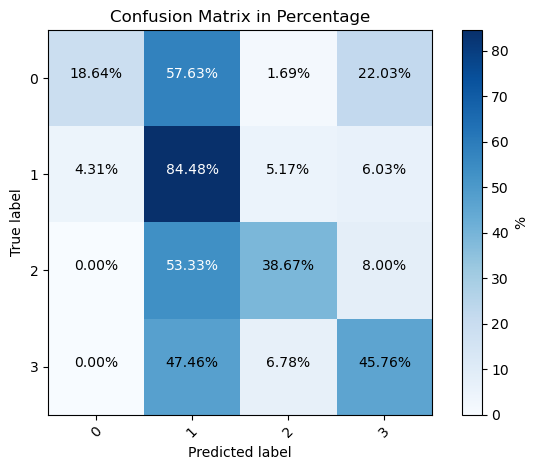

In [8]:
import matplotlib.pyplot as plt
# Normalize the matrix to get percentages
matrix = cm
normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
percentage_matrix = normalized_matrix * 100

# Plot the matrix
plt.imshow(percentage_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix in Percentage')
plt.colorbar(label='%')
tick_marks = np.arange(4)  # Adjust if you have a different number of classes
plt.xticks(tick_marks, range(4), rotation=45)
plt.yticks(tick_marks, range(4))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Display percentages on the matrix
for i in range(percentage_matrix.shape[0]):
    for j in range(percentage_matrix.shape[1]):
        plt.text(j, i, format(percentage_matrix[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if percentage_matrix[i, j] > 50 else "black")

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5339805825242718

In [10]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_1.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 22:59:22.559141: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_30_1/lstm_cell_67/recurrent_kernel/Assign' id:14469 op device:{requested: '', assigned: ''} def:{{{node lstm_30_1/lstm_cell_67/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_30_1/lstm_cell_67/recurrent_kernel, lstm_30_1/lstm_cell_67/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 22:59:23.763128: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_11_1/lstm_cell_48/recurrent_kernel/v/Assign' id:17130 op device:{requested: '', assigned: ''} def:{{{node lstm_11_1/lstm_cell_48/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_11_1/lstm_cell_48/re

Accuracy: 51.78%
Confusion Matrix:
[[16 32  2  9]
 [11 86 10  9]
 [ 0 38 31  6]
 [ 5 23  4 27]]


In [11]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.517799352750809

In [12]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_2.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 22:59:54.768855: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_38/lstm_cell_74/kernel/Assign' id:18938 op device:{requested: '', assigned: ''} def:{{{node lstm_38/lstm_cell_74/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_38/lstm_cell_74/kernel, lstm_38/lstm_cell_74/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 22:59:56.278926: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_13_2/lstm_cell_87/bias/v/Assign' id:26456 op device:{requested: '', assigned: ''} def:{{{node lstm_13_2/lstm_cell_87/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_13_2/lstm_cell_87/bias/v, lstm_13_2/lstm_cell_87/bias/v/Initializer/zeros)}}' was c

Accuracy: 54.05%
Confusion Matrix:
[[18 27  2 12]
 [ 9 87  9 11]
 [ 2 33 34  6]
 [ 7 18  6 28]]


In [13]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.540453074433657

In [14]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_3.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:00:26.573140: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_16_3/lstm_cell_127/kernel/Assign' id:30789 op device:{requested: '', assigned: ''} def:{{{node lstm_16_3/lstm_cell_127/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_16_3/lstm_cell_127/kernel, lstm_16_3/lstm_cell_127/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:00:28.450333: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_23_3/lstm_cell_134/kernel/v/Assign' id:35887 op device:{requested: '', assigned: ''} def:{{{node lstm_23_3/lstm_cell_134/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_23_3/lstm_cell_134/kernel/v, lstm_23_3/lstm_cell_134/kernel/v/Ini

Accuracy: 51.78%
Confusion Matrix:
[[18 29  3  9]
 [10 78 14 14]
 [ 2 35 34  4]
 [ 3 20  6 30]]


In [15]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.517799352750809

In [16]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_4.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:01:00.699035: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_14_4/lstm_cell_162/bias/Assign' id:39789 op device:{requested: '', assigned: ''} def:{{{node lstm_14_4/lstm_cell_162/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_14_4/lstm_cell_162/bias, lstm_14_4/lstm_cell_162/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:01:02.967785: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_24_4/lstm_cell_172/kernel/v/Assign' id:45193 op device:{requested: '', assigned: ''} def:{{{node lstm_24_4/lstm_cell_172/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_24_4/lstm_cell_172/kernel/v, lstm_24_4/lstm_cell_172/kernel/v/Initializer/zeros)}

Accuracy: 55.02%
Confusion Matrix:
[[18 28  2 11]
 [11 90  6  9]
 [ 2 36 34  3]
 [ 3 25  3 28]]


In [17]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5501618122977346

In [18]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_5.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:01:28.915446: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_34_5/lstm_cell_219/recurrent_kernel/Assign' id:52273 op device:{requested: '', assigned: ''} def:{{{node lstm_34_5/lstm_cell_219/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_34_5/lstm_cell_219/recurrent_kernel, lstm_34_5/lstm_cell_219/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:01:31.577872: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_33_5/lstm_cell_218/recurrent_kernel/v/Assign' id:54624 op device:{requested: '', assigned: ''} def:{{{node lstm_33_5/lstm_cell_218/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_33_5/lstm_cell

Accuracy: 56.31%
Confusion Matrix:
[[28 26  1  4]
 [12 88  9  7]
 [ 2 36 34  3]
 [ 2 28  5 24]]


In [19]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5631067961165048

In [20]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_6.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:02:02.771776: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_35_6/lstm_cell_257/bias/Assign' id:61733 op device:{requested: '', assigned: ''} def:{{{node lstm_35_6/lstm_cell_257/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_35_6/lstm_cell_257/bias, lstm_35_6/lstm_cell_257/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:02:05.826458: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_6_6/lstm_cell_228/kernel/m/Assign' id:62862 op device:{requested: '', assigned: ''} def:{{{node lstm_6_6/lstm_cell_228/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_6_6/lstm_cell_228/kernel/m, lstm_6_6/lstm_cell_228/kernel/m/Initializer/zeros)}}' w

Accuracy: 55.66%
Confusion Matrix:
[[22 26  1 10]
 [12 90  7  7]
 [ 3 36 32  4]
 [ 5 23  3 28]]


In [21]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5566343042071198

In [22]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_7.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:02:33.188288: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_22_7/lstm_cell_281/bias/Assign' id:68944 op device:{requested: '', assigned: ''} def:{{{node lstm_22_7/lstm_cell_281/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_22_7/lstm_cell_281/bias, lstm_22_7/lstm_cell_281/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:02:36.663364: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_35_7/lstm_cell_294/recurrent_kernel/m/Assign' id:72593 op device:{requested: '', assigned: ''} def:{{{node lstm_35_7/lstm_cell_294/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_35_7/lstm_cell_294/recurrent_kernel/m, lstm_35_7/lstm_cell_29

Accuracy: 55.34%
Confusion Matrix:
[[18 30  1 10]
 [ 9 94  4  9]
 [ 0 36 30  9]
 [ 0 27  3 29]]


In [23]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5533980582524272

In [24]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_8.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:03:05.098660: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_44/lstm_cell_296/kernel/Assign' id:74684 op device:{requested: '', assigned: ''} def:{{{node lstm_44/lstm_cell_296/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_44/lstm_cell_296/kernel, lstm_44/lstm_cell_296/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:03:09.295970: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_25_8/lstm_cell_321/bias/v/Assign' id:82382 op device:{requested: '', assigned: ''} def:{{{node lstm_25_8/lstm_cell_321/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_25_8/lstm_cell_321/bias/v, lstm_25_8/lstm_cell_321/bias/v/Initializer/zeros)}

Accuracy: 56.96%
Confusion Matrix:
[[18 28  1 12]
 [ 7 97  3  9]
 [ 0 36 31  8]
 [ 3 22  4 30]]


In [25]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.56957928802589

In [26]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_nobalance_9.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:03:38.660052: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_14_9/lstm_cell_347/kernel/Assign' id:86215 op device:{requested: '', assigned: ''} def:{{{node lstm_14_9/lstm_cell_347/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_14_9/lstm_cell_347/kernel, lstm_14_9/lstm_cell_347/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:03:42.963061: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_34_9/lstm_cell_367/bias/v/Assign' id:91808 op device:{requested: '', assigned: ''} def:{{{node lstm_34_9/lstm_cell_367/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_34_9/lstm_cell_367/bias/v, lstm_34_9/lstm_cell_367/bias/v/Initializer

Accuracy: 54.69%
Confusion Matrix:
[[21 23  0 15]
 [ 9 92  0 15]
 [ 0 41 25  9]
 [ 4 19  5 31]]


In [27]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5469255663430421